<a href="https://colab.research.google.com/github/Swayamprakashpatel/Sol_ME/blob/main/GNN_Solubility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/10, Train Loss: 6559.2092, Val RMSE: 84.8137
Epoch 2/10, Train Loss: 6036.4728, Val RMSE: 84.2578
Epoch 3/10, Train Loss: 6073.6215, Val RMSE: 83.6350
Epoch 4/10, Train Loss: 6020.1263, Val RMSE: 83.5016
Epoch 5/10, Train Loss: 6101.2821, Val RMSE: 83.4955
Epoch 6/10, Train Loss: 6101.5837, Val RMSE: 83.4718
Epoch 7/10, Train Loss: 6051.5790, Val RMSE: 84.4154
Epoch 8/10, Train Loss: 6060.5391, Val RMSE: 83.6117
Epoch 9/10, Train Loss: 6012.8570, Val RMSE: 83.4435
Epoch 10/10, Train Loss: 6051.0819, Val RMSE: 83.7960
Predictions: [49.89346  48.35382  49.172825 48.125313 49.27326  48.046547 49.396183
 52.01993  48.701042 51.836464 48.889996 48.951717 47.422153 48.325054
 48.747135 49.68279  48.385838 47.77128  47.704082 50.280964 48.851345
 48.061882 51.35605  49.058086 47.838306 49.60576  56.348457 47.70441
 49.664715 47.730915 47.085587 48.776176 50.571514 48.199707 48.791912
 47.375908 47.836338 48.304012 47.73289  48.087513 48.61912  48.97068
 48.394306 48.21871  49.93572  5

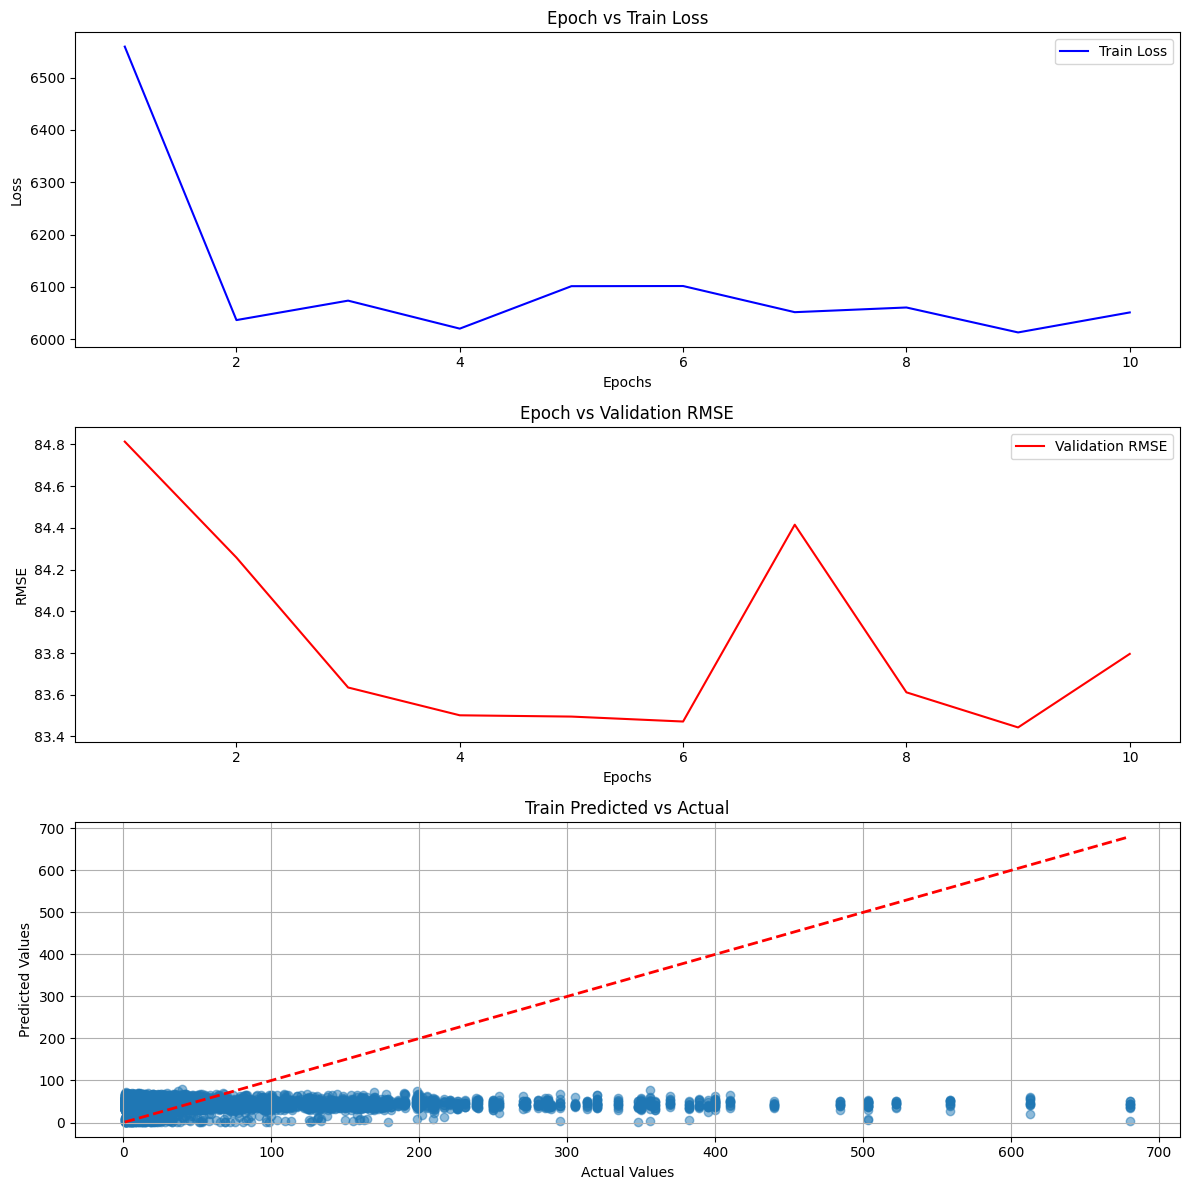

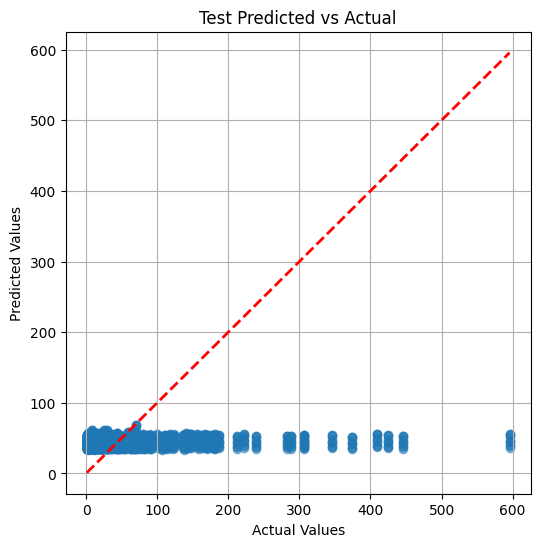

In [8]:
# Install necessary libraries
!pip install rdkit-pypi torch torch-geometric scikit-learn matplotlib

# Import required libraries
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.model_selection import train_test_split
from rdkit import Chem
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('/content/GNN_Smiles.csv')

# Define a function to convert SMILES to graph data
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    edges = []
    for bond in mol.GetBonds():
        edges.append((bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()))
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    x = torch.tensor([atom.GetAtomicNum() for atom in mol.GetAtoms()], dtype=torch.float).view(-1, 1)
    return Data(x=x, edge_index=edge_index)

# Convert SMILES to graph data
drug_graphs = [smiles_to_graph(smiles) for smiles in data['Drug_Smile']]
solvent_graphs = [smiles_to_graph(smiles) for smiles in data['Solvent_Smile']]

# Combine drug and solvent graphs
def combine_graphs(drug_graph, solvent_graph):
    x = torch.cat([drug_graph.x, solvent_graph.x], dim=0)
    edge_index = torch.cat([drug_graph.edge_index, solvent_graph.edge_index + drug_graph.x.size(0)], dim=1)
    return Data(x=x, edge_index=edge_index)

graphs = [combine_graphs(drug, solvent) for drug, solvent in zip(drug_graphs, solvent_graphs)]
labels = torch.tensor(data['Solubility'].values, dtype=torch.float)

# Prepare the dataset
train_graphs, test_graphs, train_labels, test_labels = train_test_split(graphs, labels, test_size=0.2, random_state=42)

# Define the GNN model
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(1, 64)
        self.conv2 = GCNConv(64, 128)
        self.fc = torch.nn.Linear(128, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = global_mean_pool(x, data.batch)
        x = self.fc(x)
        return x

# Define early stopping and model checkpointing based on RMSE
class EarlyStopping:
    def __init__(self, patience=15, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_rmse = float('inf')
        self.wait = 0
        self.stop = False

    def __call__(self, val_rmse):
        if val_rmse < self.best_rmse - self.delta:
            self.best_rmse = val_rmse
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stop = True

early_stopping = EarlyStopping(patience=15, delta=0.01)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

# Initialize lists to store metrics and predictions
train_losses = []
val_rmse_list = []
train_predictions = []
train_actuals = []
test_predictions = []
test_actuals = []

# Create data loaders
def collate_fn(data_list):
    graphs, labels = zip(*data_list)
    batch = Data.from_data_list(graphs)
    return batch, torch.tensor(labels, dtype=torch.float)

train_loader = DataLoader(list(zip(train_graphs, train_labels)), batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(list(zip(test_graphs, test_labels)), batch_size=32, shuffle=False, collate_fn=collate_fn)

# Define functions for training and validation
def train():
    model.train()
    total_loss = 0
    for batch_graph, batch_labels in train_loader:
        batch_graph = batch_graph.to(device)
        batch_labels = batch_labels.to(device)
        optimizer.zero_grad()
        out = model(batch_graph)
        loss = criterion(out.squeeze(), batch_labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Collect training predictions
        train_predictions.extend(out.cpu().detach().numpy())
        train_actuals.extend(batch_labels.cpu().numpy())

    return total_loss / len(train_loader)

def validate():
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_graph, batch_labels in test_loader:
            batch_graph = batch_graph.to(device)
            batch_labels = batch_labels.to(device)
            out = model(batch_graph)
            loss = criterion(out.squeeze(), batch_labels)
            val_loss += loss.item()

            # Collect test predictions
            test_predictions.extend(out.cpu().detach().numpy())
            test_actuals.extend(batch_labels.cpu().numpy())

    rmse = np.sqrt(val_loss / len(test_loader))
    return rmse

# Training loop with early stopping and model checkpointing based on RMSE
num_epochs = 10
best_rmse = float('inf')

for epoch in range(num_epochs):
    train_loss = train()
    val_rmse = validate()

    train_losses.append(train_loss)
    val_rmse_list.append(val_rmse)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val RMSE: {val_rmse:.4f}')

    if val_rmse < best_rmse:
        best_rmse = val_rmse
        torch.save(model.state_dict(), 'best_model.pth')  # Save the model checkpoint

    early_stopping(val_rmse)
    if early_stopping.stop:
        print('Early stopping triggered.')
        break

# Load the best model for evaluation
model.load_state_dict(torch.load('best_model.pth', weights_only=True))

# Evaluate the model
model.eval()
predictions = []
with torch.no_grad():
    for batch_graph, _ in test_loader:
        batch_graph = batch_graph.to(device)
        pred = model(batch_graph)
        predictions.extend(pred.cpu().numpy())
predictions = np.concatenate(predictions)

print("Predictions:", predictions)
print("True Labels:", np.array(test_actuals))

# Plotting the metrics
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 12))

# Training Loss
plt.subplot(3, 1, 1)
plt.plot(epochs, train_losses, 'b', label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epoch vs Train Loss')
plt.legend()

# Validation RMSE
plt.subplot(3, 1, 2)
plt.plot(epochs, val_rmse_list, 'r', label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Epoch vs Validation RMSE')
plt.legend()

# Predicted vs Actual (Train)
plt.subplot(3, 1, 3)
train_predictions = np.array(train_predictions)
train_actuals = np.array(train_actuals)
plt.scatter(train_actuals, train_predictions, alpha=0.5)
plt.plot([train_actuals.min(), train_actuals.max()], [train_actuals.min(), train_actuals.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Train Predicted vs Actual')
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot Predicted vs Actual (Test)
plt.figure(figsize=(6, 6))
test_predictions = np.array(test_predictions)
test_actuals = np.array(test_actuals)
plt.scatter(test_actuals, test_predictions, alpha=0.5)
plt.plot([test_actuals.min(), test_actuals.max()], [test_actuals.min(), test_actuals.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Test Predicted vs Actual')
plt.grid(True)
plt.show()
